# Import models
Download models and place in 

In [ ]:
# Define path
path = <path_to_data>

In [2]:
# import CNN models
import tensorflow as tf
models_byfold = list()
for fold in range(0,5):
    models = list()
    for model in range(0,5):
        path = path + '/saved_models/ensemblemodel_' + str(fold) + '-' + str(model)
        model = tf.keras.models.load_model(path)
        models.append(model)
    models_byfold.append(models)

In [3]:
# import MLP models
import pickle as pkl
file = open(path+'MLP/mlp_models_byfold.pkl', 'rb')
pipes_byfold = pkl.load(file)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use 

# Import testing data

In [6]:
import numpy as np
from keras.utils import to_categorical
# import train and test data
path = '/content/drive/MyDrive/COLAB/saved_models/'

file_test = np.load(path + 'file_test_byfold.npy', allow_pickle=True)

X_test_cnn = list()
X_test_mlp = list()
y_true_mlp = list()
y_true_cnn = list()

for i in range(0,5):
    Xtestcnn = np.load(path+'X_test_' + str(i) + '.dat', allow_pickle=True)
    nsamples, nx, ny, nz = Xtestcnn.shape
    Xtestmlp = Xtestcnn.reshape((nsamples, nx*ny*nz))*255

    ytruemlp = np.load(path+'Y_true_' + str(i) + '.dat', allow_pickle=True)
    ytruecnn = to_categorical(ytruemlp)

    file = np.load(path+'Y_true_' + str(i) + '.dat', allow_pickle=True)
    
    X_test_cnn.append(Xtestcnn)
    X_test_mlp.append(Xtestmlp)

    y_true_mlp.append(ytruemlp)
    y_true_cnn.append(ytruecnn)

# Evaluate and get metrics

In [7]:
threshold_cnn = 0.2
threshold_mlp = 0.9
y_preds_cnn = list()
y_preds_mlp = list()

for fold in range(0,5):

    print(fold)

    y_p_mlp = [pipe.predict_proba(X_test_mlp[fold])[:,1] for pipe in pipes_byfold[fold]]
    y_p_mlp = np.array(y_p_mlp)
 
    y_p_cnn = [model.predict(X_test_cnn[fold])[:,1] for model in models_byfold[fold]]
    y_p_cnn = np.array(y_p_cnn)

    y_preds_cnn.append(y_p_cnn)
    y_preds_mlp.append(y_p_mlp) 


0
1
2
3
4


In [10]:
# combine CNN and MLP predictions, scaled according to optimal threshold (calculated from ROC curves)
y_preds_all=list()
y_preds_mlp_mean = list()
y_preds_cnn_mean = list()

MLPthresh = 0.9
CNNthresh = 0.2

for fold in range(0,5):
    outs_cnn = np.mean(y_preds_cnn[fold], axis=0)
    outs_mlp = np.mean(y_preds_mlp[fold], axis=0)
    
    ypa = (outs_cnn*MLPthresh/CNNthresh + outs_mlp*CNNthresh/MLPthresh)

    y_preds_all.append(ypa)
    y_preds_mlp_mean.append(outs_mlp)
    y_preds_cnn_mean.append(outs_cnn)

In [11]:
cm_mean = []

# get threshold from calculations below
threshold = 1.2

for fold in range(0,5):

   # cm_mlp = tf.math.confusion_matrix(labels=y_true_mlp[fold], predictions=y_preds_mlp[fold]).numpy()
    #cm_cnn = tf.math.confusion_matrix(labels=y_true_mlp[fold], predictions=y_preds_cnn[fold]).numpy()
    y_preds_int = (y_preds_all[fold] > threshold).astype('int32')
    
    cm = tf.math.confusion_matrix(labels=y_true_mlp[fold], predictions=y_preds_int).numpy()
    cm_mean.append(cm)
    print(fold)
   # print(cm_mlp)
   # print(cm_cnn)
    print(cm)
    print('')

print('Mean cm: ')
cm_mean = np.mean(cm_mean, axis=0)
print(cm_mean)

reduction = 1 - ( (cm_mean[0][1] + cm_mean[1][1] )/ np.sum(cm_mean))
print('reduction in candidate circles = ', reduction)

recall = cm_mean[1][1] / (cm_mean[1][0] + cm_mean[1][1])
print('recall = ', recall)

0
[[1106  164]
 [   5   62]]

1
[[1122  148]
 [   8   59]]

2
[[1111  159]
 [   8   59]]

3
[[1120  149]
 [  16   51]]

4
[[1148  121]
 [  11   56]]

Mean cm: 
[[1121.4  148.2]
 [   9.6   57.4]]
reduction in candidate circles =  0.8461768666766423
recall =  0.8567164179104477


84
Threshold value is: 1.4861850870980158
84
Threshold value is: 1.1592806710137262
74
Threshold value is: 1.2992586970739333
105
Threshold value is: 0.2236499910682647
82
Threshold value is: 0.8814795149695924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

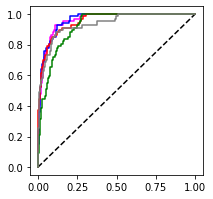

In [39]:
# this cell prints a chart with ROC curves, and also calculates optimal threshold for each fold
# print CMs and ROC curves for each fold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

threshold = 0.2

cm_byfold = list()
thresh_byfold = list()

# fig size
mpl.rcParams['figure.figsize'] = (3.1, 3.1)

fig = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

colors = ['magenta', 'blue', 'red', 'green', 'gray']

# add all curves for full model
for fold in range(0,5):

    fpr, tpr, thresholds = roc_curve(y_true_mlp[fold], y_preds_all[fold])
    print(len(tpr))
    aucurve = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)

    thresh_byfold.append(optimal_threshold)
    plt.plot(fpr, tpr, label='Fold ' + str(fold+1) + ' (area = {:.3f})'.format(aucurve), color=colors[fold])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves by training fold')
plt.legend(loc='best')    
plt.show()

fig.savefig('/content/drive/MyDrive/COLAB/figs/roc_curves_by_fold_MLP_CNN.jpg',
            format='jpg',
            dpi=600,
            bbox_inches='tight')


##print('mean CM using threshold: ')
#meancm = np.mean(cm_byfold, axis=0)
#print(meancm)

mean_thresh = np.mean(thresh_byfold)
print('mean threshold: ', mean_thresh)

# Aggregate map pages

In [ ]:
# select data for analysis. run this cell to select unfiltered data
import pandas as pd
dfs = list()

for fold in range(0,5):
  df = pd.DataFrame()

  y_p = (y_preds_all[fold] > 1.2).astype('int32')

  df['filenames'] = file_test[fold]
  df['true'] = y_true_mlp[fold]
  df['pred'] = y_p

  dfs.append(df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import random

mpl.rcParams['figure.figsize'] = (6.5, 20)


# aggregate map pages and return list of true pos and false pos, etc
cms = list()
map_num=list()
maps_cm = list()

for fold in range(0,5):
  print(fold)
  df = dfs[fold]
  df['file'] = df['filenames'].str.rstrip('.jpg').astype(str)
  df['map'] = df['filenames'].str.split('-').str[0] + '-' + df['filenames'].str.split('-').str[1]
  df['volume'] = df['map'].str.split('-').str[0]
  df['city'] = df['file'].str.split('_').str[0]
  df['year'] = df['file'].str.split('-').str[0]
  df['year'] = df['year'].str.split('_').str[-1]
  df['cityyear'] = df['city'] + '_' + df['year']

  # full dfs, split
  df_tp = df.loc[(df['pred'] == 1) & (df['true'] == 1)]
  df_fp = df.loc[(df['pred'] == 1) & (df['true'] == 0)]
  df_tn = df.loc[(df['pred'] == 0) & (df['true'] == 0)]
  df_fn = df.loc[(df['pred'] == 0) & (df['true'] == 1)]

  # get num maps
  maps = np.unique(df['map'])
  map_num = len(maps)

  # get unique values from each list of maps
  tp = set(np.unique(df_tp['map']))
  fp = set(np.unique(df_fp['map']))
  fn = set(np.unique(df_fn['map']))
  tn = set(np.unique(df_tn['map']))


  tp_fp_fn_tn = []
  tp_fp_fn    = []
  fp_fn_tn    = []
  tp_fp       = []
  tp_fn       = []
  tp_tn       = []
  fp_fn       = []
  fp_tn       = []
  fn_tn       = []
  tp_only = []
  fp_only = []
  tn_only = []
  fn_only = []

  # sort maps based on intersections
  for map in np.unique(df['map']):
    if map in tp&fp&fn&tn:
      tp_fp_fn_tn.append(map)
    elif map in tp&fp&fn:
      tp_fp_fn.append(map)
    elif map in fp&fn&tn:
      fp_fn_tn.append(map)
    elif map in tp&fp:
      tp_fp.append(map)
    elif map in tp&fn:
      tp_fn.append(map)
    elif map in tp&tn:
      tp_tn.append(map)
    elif map in fp&fn:
      fp_fn.append(map)
    elif map in fn&tn:
      fp_tn.append(map)
    elif map in fn&tn:
      fn_tn.append(map)
    elif map in tp:
      tp_only.append(map)
    elif map in fp:
      fp_only.append(map)
    elif map in tn:
      tn_only.append(map)
    elif map in fn:
      fn_only.append(map)
        
  # construct final values. TP = any map with TP. FP = any map with FP but no TP. FN = any map with FN. TN = all TN-only maps.
  tp_final = tp_only + tp_fp_fn_tn + tp_fp_fn + tp_fp + tp_fn + tp_tn + fp_fn + fp_fn_tn
  fp_final = fp_only + fp_tn
  fn_final = fn_only + fn_tn
  tn_final = tn_only
 
  print(fn_final)

  print('cm of just the number of maps in each category: ')
  map_cm = np.array([[len(tn), len(fp)], [len(fn), len(tp)]])
  maps_cm.append(map_cm)
  print(map_cm)
  

  cm_final = np.array([[len(tn_final), len(fp_final)], [len(fn_final), len(tp_final)]])
  print('final cm after accounting for recovered maps: ')
  print(cm_final)
  cms.append(cm_final)

cms = np.array(cms)
final_cm = np.sum(cms, axis=0)
print('final cm total, adding all CMS above: ')
print(final_cm)

print('mean number of maps per fold: ', np.mean(np.array(map_num)))

print('Mean total map cm: ')
maps_mean = np.mean(maps_cm, axis=0)
print(maps_mean)


print('Mean final cm, after accounting for recovered maps: ')
cm_mean = np.mean(cms, axis=0)
print(cm_mean)

reduction = 1 - ( (cm_mean[0][1] + cm_mean[1][1] )/ np.sum(cm_mean))
print('reduction in candidate maps = ', reduction)

recall = cm_mean[1][1] / (cm_mean[1][0] + cm_mean[1][1])
print('recall = ', recall)

0
['01790_08_1950-0118', '03376_01_1885-0026L', '08106_1891-0011', '08108_1898-0011']
cm of just the number of maps in each category: 
[[926 131]
 [  5  57]]
final cm after accounting for recovered maps: 
[[881 125]
 [  4  57]]
1
['01790_B_1909-0067', '06116_08_1896-0170R', '08099_01_1899-0027', '08099_02_1900-0166', '08106_1912-0005']
cm of just the number of maps in each category: 
[[919 123]
 [  8  54]]
final cm after accounting for recovered maps: 
[[874 117]
 [  5  54]]
2
['06198_05_1903-0011', '07439_02_1901-0179', '08096_1890-0035', '08099_01_1889-0026L']
cm of just the number of maps in each category: 
[[940 123]
 [  7  53]]
final cm after accounting for recovered maps: 
[[891 119]
 [  4  53]]
3
['00813_04_1893-0094R', '03376_07_1937-0712', '03376_07_1950-0712', '06116_05_1899-0099L', '06116_A_1898-0018', '06198_04_1901-0110', '07439_01_1950-0061', '07439_04_1909-0354', '08099_06_1921-0080', '08108_1903-0026']
cm of just the number of maps in each category: 
[[944 124]
 [ 15  4